In [125]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd
%matplotlib inline

In [2]:
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
import orca
import os; os.chdir('../')
import warnings;warnings.simplefilter('ignore')
from scripts import datasources, models, variables

In [3]:
county_dict = {
    'Alameda': '001', 'Contra Costa': '013', 'Marin': '041', 'Napa': '055', 'San Francisco': '075',
    'San Mateo': '081', 'Santa Clara': '085', 'Solano': '095', 'Sonoma': '097'
}

In [7]:
persons_w_jobs = pd.read_csv('./data/persons_w_jobs_2018_10_16.csv', index_col='person_id')

### Aggregate WLCM-assigned commute flows

In [5]:
orca.run(['initialize_network_small', 'initialize_network_walk'])

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s


In [8]:
orca.add_table('persons', persons_w_jobs)

In [11]:
orca.broadcast('jobs', 'persons', cast_index=True, onto_on='job_id')

In [12]:
df_hh_geog = orca.merge_tables('persons', ['persons', 'households', 'units', 'buildings', 'parcels'])[['block_id']]

In [13]:
df_w_geog = orca.merge_tables('persons', ['persons', 'jobs', 'buildings', 'parcels'])[['block_id']]

In [101]:
ods = pd.merge(df_hh_geog, df_w_geog, left_index=True, right_index=True, suffixes=('_h', '_w'))

In [102]:
ods['tract_id_h'] = ods['block_id_h'].str[0:11]
ods['county_id_h'] = ods['block_id_h'].str[0:5]
ods['tract_id_w'] = ods['block_id_w'].str[0:11]
ods['county_id_w'] = ods['block_id_w'].str[0:5]

In [38]:
ods = ods[['county_id_h', 'county_id_w']]

In [103]:
od_county_counts = ods[['county_id_h', 'county_id_w']].reset_index().groupby(['county_id_h', 'county_id_w']).count().reset_index().rename(columns={'person_id': 'count'})
od_tract_counts = ods[['tract_id_h', 'tract_id_w']].reset_index().groupby(['tract_id_h', 'tract_id_w']).count().reset_index().rename(columns={'person_id': 'count'})

### Aggregate LODES data

In [160]:
lodes = pd.read_csv(
    'https://lehd.ces.census.gov/data/lodes/LODES7/ca/od/ca_od_main_JT01_2011.csv.gz',
    dtype={'w_geocode': str, 'h_geocode': str}, usecols=['w_geocode', 'h_geocode', 'S000'],
    compression='gzip')

In [161]:
lodes['tract_id_h'] = lodes['h_geocode'].str[0:11]
lodes['county_id_h'] = lodes['h_geocode'].str[0:5]
lodes['tract_id_w'] = lodes['w_geocode'].str[0:11]
lodes['county_id_w'] = lodes['w_geocode'].str[0:5]

In [162]:
lodes_county_od_counts = lodes[['county_id_h', 'county_id_w', 'S000']].groupby(['county_id_h', 'county_id_w']).sum().reset_index().rename(columns={'S000': 'count'})
lodes_tract_od_counts = lodes[['tract_id_h', 'tract_id_w', 'S000']].groupby(['tract_id_h', 'tract_id_w']).sum().reset_index().rename(columns={'S000': 'count'})

### High-level comparison of WLCM to LODES

In [191]:
merged_county['count_lodes'].sum()

2541333

In [192]:
merged_county['count_synth'].sum()

1647674

In [193]:
(merged_county['count_lodes'].sum() - merged_county['count_synth'].sum())/merged_county['count_lodes'].sum()

-0.3516497050957116

### Merge WLCM results with LODES

In [115]:
merged_county = pd.merge(od_county_counts, lodes_county_od_counts, on=['county_id_h', 'county_id_w'], suffixes=('_synth', '_lodes'))
merged_tract = pd.merge(od_tract_counts, lodes_tract_od_counts, on=['tract_id_h', 'tract_id_w'], suffixes=('_synth', '_lodes'))

In [197]:
merged_county['pct_synth'] = merged_county['count_synth'] / merged_county['count_synth'].sum()
merged_county['pct_lodes'] = merged_county['count_lodes'] / merged_county['count_lodes'].sum()
merged_county['normed_pct_diff'] = merged_county['pct_lodes'] - merged_county['pct_synth']
merged_tract['pct_synth'] = merged_tract['count_synth'] / merged_tract['count_synth'].sum()
merged_tract['pct_lodes'] = merged_tract['count_lodes'] / merged_tract['count_lodes'].sum()
merged_tract['normed_pct_diff'] = merged_tract['pct_lodes'] - merged_tract['pct_synth']

### County-level flows

In [116]:
merged_county['pct_diff'] = (merged_county['count_lodes'] - merged_county['count_synth']) / merged_county['count_lodes'] * 100

Text(0.5,1,'County-to-County Commute Flow Counts: \nSynthetic vs. LEHD Origin-Destination Employment Statistics')

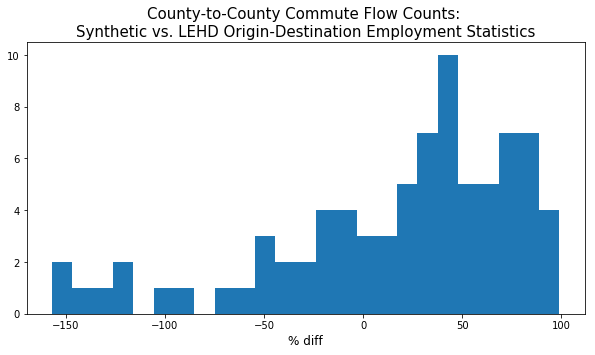

In [122]:
fig, ax = plt.subplots(figsize=(10,5))
_ = ax.hist(merged_county['pct_diff'], bins=25)
ax.set_xlabel('% diff', fontsize=12)
ax.set_title('County-to-County Commute Flow Counts: \nSynthetic vs. LEHD Origin-Destination Employment Statistics', fontsize=15)

Text(0.5,1,'County-to-County Commute Flow Counts: \nSynthetic vs. LEHD Origin-Destination Employment Statistics')

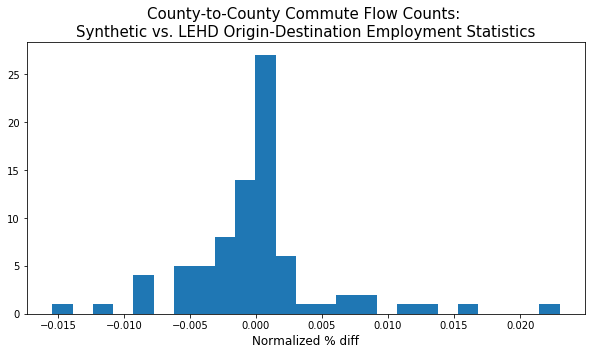

In [198]:
fig, ax = plt.subplots(figsize=(10,5))
_ = ax.hist(merged_county['normed_pct_diff'], bins=25)
ax.set_xlabel('Normalized % diff', fontsize=12)
ax.set_title('County-to-County Commute Flow Counts: \nSynthetic vs. LEHD Origin-Destination Employment Statistics', fontsize=15)

Text(0.5,0,'LODES')

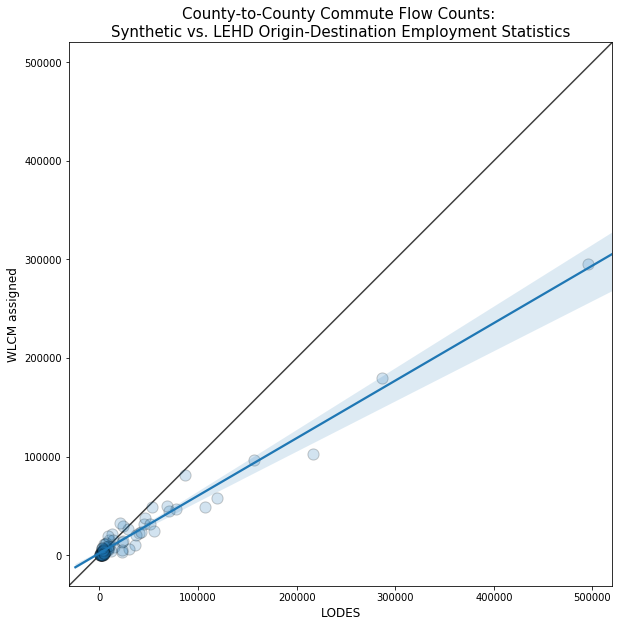

In [184]:
fig, ax = plt.subplots(figsize=(10,10))
sns.regplot(
    'count_lodes', 'count_synth', merged_county,
    ax=ax, marker='.', fit_reg=True,
    scatter_kws={"s": 500, "edgecolor": 'k', "alpha": 0.2})

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('County-to-County Commute Flow Counts: \nSynthetic vs. LEHD Origin-Destination Employment Statistics', fontsize=15)
ax.set_ylabel('WLCM assigned', fontsize=12)
ax.set_xlabel('LODES', fontsize=12)

Text(0.5,0,'LODES')

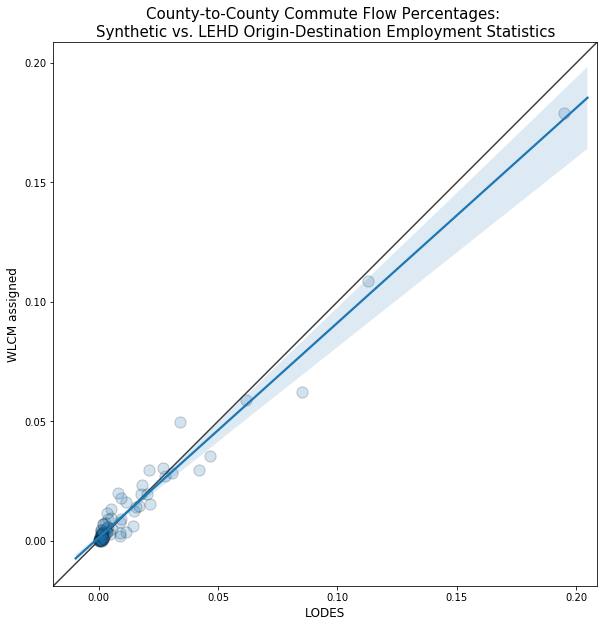

In [199]:
fig, ax = plt.subplots(figsize=(10,10))
sns.regplot(
    'pct_lodes', 'pct_synth', merged_county,
    ax=ax, marker='.', fit_reg=True,
    scatter_kws={"s": 500, "edgecolor": 'k', "alpha": 0.2})

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('County-to-County Commute Flow Percentages: \nSynthetic vs. LEHD Origin-Destination Employment Statistics', fontsize=15)
ax.set_ylabel('WLCM assigned', fontsize=12)
ax.set_xlabel('LODES', fontsize=12)

### Commute Distance Distributions

In [154]:
blocks = gpd.read_file('./data/Blocks/bayarea_blocks.shp')

In [156]:
blocks = blocks.to_crs(crs={'init': 'epsg:2768'})

In [157]:
blocks['centroid'] = blocks['geometry'].centroid

In [164]:
lodes = lodes[['h_geocode','w_geocode']].merge(blocks, left_on='w_geocode', right_on='blockid10')

In [165]:
lodes = lodes.merge(blocks, left_on='h_geocode', right_on='blockid10', suffixes=('_w', '_h'))

In [166]:
lodes['distance_m'] = gpd.GeoSeries(lodes['centroid_h']).distance(gpd.GeoSeries(lodes['centroid_w']))

In [169]:
ods = ods[['block_id_h','block_id_w']].merge(blocks, left_on='block_id_w', right_on='blockid10')

In [170]:
ods = ods.merge(blocks, left_on='block_id_h', right_on='blockid10', suffixes=('_w', '_h'))

In [171]:
ods['distance_m'] = gpd.GeoSeries(ods['centroid_h']).distance(gpd.GeoSeries(ods['centroid_w']))

Text(0.5,0,'Census Block to Census Block Commute Distances (m)')

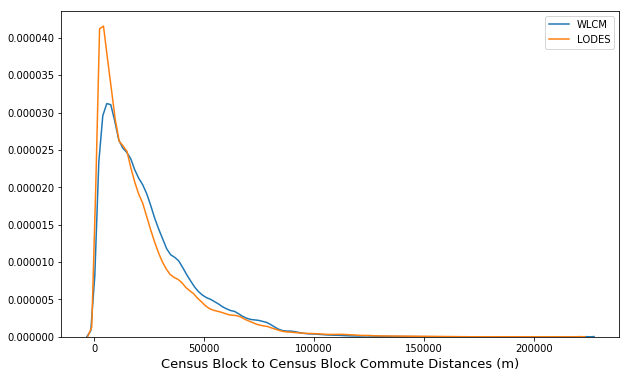

In [180]:
fig, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(ods['distance_m'],ax=ax, label='WLCM')
sns.kdeplot(lodes['distance_m'], ax=ax, label='LODES')
ax.set_xlabel('Census Block to Census Block Commute Distances (m)', fontsize=13)